In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

In [10]:
customers = pd.read_csv("Customers.csv")
transactions = pd.read_csv("Transactions.csv")

In [11]:
print("Customers Data:")
print(customers.head())
print("\nTransactions Data:")
print(transactions.head())

Customers Data:
  CustomerID        CustomerName         Region  SignupDate
0      C0001    Lawrence Carroll  South America  2022-07-10
1      C0002      Elizabeth Lutz           Asia  2022-02-13
2      C0003      Michael Rivera  South America  2024-03-07
3      C0004  Kathleen Rodriguez  South America  2022-10-09
4      C0005         Laura Weber           Asia  2022-08-15

Transactions Data:
  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127      P067  2024-04-25 07:38:55         1   
3        T00272      C0087      P067  2024-03-26 22:55:37         2   
4        T00363      C0070      P067  2024-03-21 15:10:10         3   

   TotalValue   Price  
0      300.68  300.68  
1      300.68  300.68  
2      300.68  300.68  
3      601.36  300.68  
4      902.04  300.68  


In [12]:
data = pd.merge(transactions, customers, on="CustomerID")

In [13]:
data.head()

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price,CustomerName,Region,SignupDate
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68,Andrea Jenkins,Europe,2022-12-03
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68,Brittany Harvey,Asia,2024-09-04
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68,Kathryn Stevens,Europe,2024-04-04
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68,Travis Campbell,South America,2024-04-11
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68,Timothy Perez,Europe,2022-03-15


In [14]:
# Feature Engineering: Aggregating transaction data
agg_data = data.groupby("CustomerID").agg(
    TotalQuantity=("Quantity", "sum"),
    TotalSpending=("TotalValue", "sum"),
    AveragePrice=("Price", "mean"),
    DistinctProducts=("ProductID", "nunique"),
    TransactionFrequency=("TransactionID", "count"),
    LastTransactionDate=("TransactionDate", "max")
).reset_index()

In [15]:
# Calculate recency (days since last transaction)
agg_data['Recency'] = (pd.to_datetime("2025-01-27") - pd.to_datetime(agg_data['LastTransactionDate'])).dt.days
agg_data.drop("LastTransactionDate", axis=1, inplace=True)

In [16]:
profile_data = customers[["CustomerID", "Region"]]
final_data = pd.merge(agg_data, profile_data, on="CustomerID")
final_data = pd.get_dummies(final_data, columns=["Region"], drop_first=True)


In [17]:
scaler = StandardScaler()
features = final_data.drop(["CustomerID"], axis=1)
scaled_features = scaler.fit_transform(features)


In [18]:
dbi_scores = []
silhouette_scores = []
cluster_range = range(2, 11)

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(scaled_features)
    dbi_scores.append(davies_bouldin_score(scaled_features, labels))
    silhouette_scores.append(silhouette_score(scaled_features, labels))


In [19]:
optimal_clusters = cluster_range[np.argmin(dbi_scores)]

In [20]:
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
final_labels = kmeans.fit_predict(scaled_features)
final_data["Cluster"] = final_labels


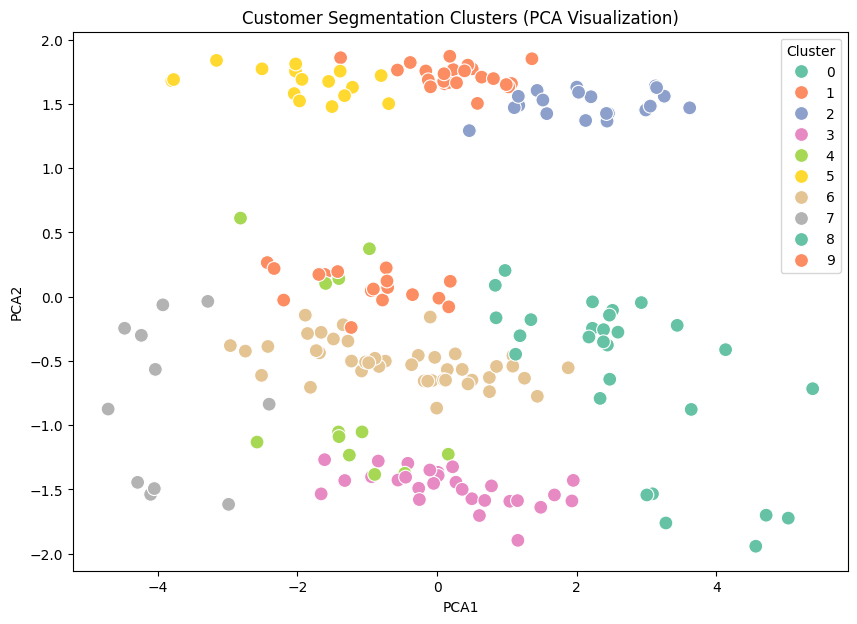

In [21]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)
final_data["PCA1"] = pca_features[:, 0]
final_data["PCA2"] = pca_features[:, 1]

plt.figure(figsize=(10, 7))
sns.scatterplot(data=final_data, x="PCA1", y="PCA2", hue="Cluster", palette="Set2", s=100)
plt.title("Customer Segmentation Clusters (PCA Visualization)")
plt.show()


In [22]:
print(f"Optimal number of clusters: {optimal_clusters}")
print(f"Davies-Bouldin Index: {min(dbi_scores):.2f}")
print(f"Silhouette Score: {max(silhouette_scores):.2f}")


Optimal number of clusters: 10
Davies-Bouldin Index: 1.21
Silhouette Score: 0.28
